In [20]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### How can I identify similar Marathon performances?

In [21]:
df = pd.read_csv('results.csv')
df.head()

,10k,name,division,25k,gender,age,official,bib,genderdiv,ctz,...,overall,pace,state,30k,5k,half,20k,country,city,40k
0,17.37,"Yamamoto, Hiroyuki",8,47.67,M,47,85.25,W1,8,NaN,...,8,3.27,NaN,59.18,8.02,39.72,37.65,JPN,Fukuoka,80.43
1,32.58,"Jeptoo, Rita",1,82.43,F,33,138.95,F1,1,NaN,...,21,5.30,NaN,99.33,16.22,69.47,65.83,KEN,Eldoret,132.10
2,16.62,"Van Dyk, Ernst F.",1,45.80,M,41,80.60,W2,1,NaN,...,1,3.08,NaN,56.45,7.75,38.03,36.10,RSA,Paarl,76.10
3,32.57,"Dibaba, Mare",3,82.43,F,24,140.58,F2,3,NaN,...,27,5.37,NaN,99.33,16.20,69.47,65.83,ETH,Shoa,132.95
4,17.12,"Hokinoue, Kota",2,46.37,M,40,81.23,W3,2,NaN,...,2,3.10,NaN,57.03,8.02,38.60,36.58,JPN,Nogata Fukuoka,76.72


In [22]:
# Data Cleaning

# Drop ctz and state column
#df = df.drop(['ctz', 'state'], 1)

# Drop row in city where there's a null value
df = df.dropna(subset=['city'])

# Replace values that represent null
df = df.replace('-', np.nan)

# Convert types to numeric
df[['10k', '25k', '35k', '30k', '5k', 'half', '20k', '40k']] = df[['10k', '25k', '35k', '30k', '5k', 'half', '20k', '40k']].apply(pd.to_numeric)

# Impute null with means
df = df.fillna(df.mean())

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31983 entries, 0 to 31983
Data columns (total 21 columns):
10k          31983 non-null float64
name         31983 non-null object
division     31983 non-null int64
25k          31983 non-null float64
gender       31983 non-null object
age          31983 non-null int64
official     31983 non-null float64
bib          31983 non-null object
genderdiv    31983 non-null int64
ctz          1244 non-null object
35k          31983 non-null float64
overall      31983 non-null int64
pace         31983 non-null float64
state        29408 non-null object
30k          31983 non-null float64
5k           31983 non-null float64
half         31983 non-null float64
20k          31983 non-null float64
country      31983 non-null object
city         31983 non-null object
40k          31983 non-null float64
dtypes: float64(10), int64(4), object(7)
memory usage: 5.4+ MB


In [24]:
# Make categorical variables numeric using label encoder
#labelencoder = LabelEncoder()
#labelencoder.fit(features['gender'])
#features['gender'] = labelencoder.transform(features['gender'])

#features = pd.get_dummies(features, columns = ['country', 'city', 'gender'])

df['gender'] = pd.get_dummies(df.gender, drop_first=True)
df['citizen'] = pd.get_dummies(df.ctz.notna(), drop_first=True)
df['american'] = pd.get_dummies(df.state.notna(), drop_first=True)

# Create features
features = df.drop(['state', 'ctz', 'name', 'city', 'country', 'bib'], 1)

features.head()

,10k,division,25k,gender,age,official,genderdiv,35k,overall,pace,30k,5k,half,20k,40k,citizen,american
0,17.37,8,47.67,1,47,85.25,8,71.40,8,3.27,59.18,8.02,39.72,37.65,80.43,0,0
1,32.58,1,82.43,0,33,138.95,1,116.37,21,5.30,99.33,16.22,69.47,65.83,132.10,0,0
2,16.62,1,45.80,1,41,80.60,1,67.42,1,3.08,56.45,7.75,38.03,36.10,76.10,0,0
3,32.57,3,82.43,0,24,140.58,3,116.37,27,5.37,99.33,16.20,69.47,65.83,132.95,0,0
4,17.12,2,46.37,1,40,81.23,2,67.83,2,3.10,57.03,8.02,38.60,36.58,76.72,0,0


In [25]:
features.describe()

,10k,division,25k,gender,age,official,genderdiv,35k,overall,pace,30k,5k,half,20k,40k,citizen,american
count,31983.000000,31983.000000,31983.000000,31983.000000,31983.000000,31983.000000,31983.000000,31983.000000,31983.000000,31983.000000,31983.000000,31983.000000,31983.000000,31983.000000,31983.000000,31983.000000,31983.000000
mean,51.799330,1932.615858,133.612261,0.550824,42.406716,242.997837,8051.148579,196.857981,15939.640340,9.275678,164.571509,25.755576,111.664729,105.711824,229.001976,0.038896,0.919488
std,8.958637,1715.229489,25.510748,0.497418,11.316488,52.301165,4754.043678,41.957391,9233.117792,1.992514,33.932935,4.324377,21.037777,19.765037,49.130612,0.193349,0.272088
min,16.620000,1.000000,45.800000,0.000000,18.000000,80.600000,1.000000,67.420000,1.000000,3.080000,56.450000,7.750000,38.030000,36.100000,76.100000,0.000000,0.000000
25%,45.420000,610.000000,115.570000,0.000000,33.000000,205.525000,3972.000000,167.150000,7943.500000,7.850000,140.690000,22.650000,96.870000,91.770000,193.830000,0.000000,1.000000
50%,50.350000,1425.000000,129.070000,1.000000,42.000000,232.370000,7970.000000,188.220000,15940.000000,8.870000,157.780000,25.100000,107.880000,102.180000,218.900000,0.000000,1.000000
75%,57.150000,2611.000000,147.560000,1.000000,50.000000,273.240000,11968.000000,220.120000,23935.500000,10.430000,182.790000,28.460000,123.030000,116.480000,257.410000,0.000000,1.000000
max,112.380000,6979.000000,289.020000,1.000000,81.000000,538.880000,17575.000000,449.330000,31931.000000,20.570000,376.380000,86.950000,236.670000,224.350000,508.350000,1.000000,1.000000


In [26]:
# Assign training and target variables
x = features.drop(columns=['american', 'division', 'gender', 'age', 'official', 'genderdiv', 'overall', 'pace', 'citizen', 'american', 'gender'])
y = features['american']

# Normalize Data
x_norm = normalize(x)

# Create PCAs for all distance interval
x_pca = PCA(2).fit_transform(x)
df_x_pca = pd.DataFrame(data=x_pca, columns=['PCA1', 'PCA2'])

features = features.drop(columns = ['10k', '25k', '35k', '30k', '5k', 'half', '20k', '40k'])
features['PCA1'] = df_x_pca['PCA1']
features['PCA2'] = df_x_pca['PCA2']

In [27]:
features.head()

,division,gender,age,official,genderdiv,overall,pace,citizen,american,PCA1,PCA2
0,8,1,47,85.25,8,8,3.27,0,0,-259.423072,15.148024
1,1,0,33,138.95,1,21,5.30,0,0,-162.941983,2.648973
2,1,1,41,80.60,1,1,3.08,0,0,-266.575317,14.780058
3,3,0,24,140.58,3,27,5.37,0,0,-162.440031,3.174286
4,2,1,40,81.23,2,2,3.10,0,0,-265.269178,14.296303


In [28]:
# Define Targt and training variables
X = features.drop('american', 1)
Y = features.american

In [29]:
# Create training set of 10% of the data
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.9, random_state=42)

In [30]:
x_train.head()

,division,gender,age,official,genderdiv,overall,pace,citizen,PCA1,PCA2
28142,1178,0,51,288.82,11243,25970,11.02,0,66.555762,-7.596165
17564,1929,0,44,294.50,11588,26659,11.23,0,-8.862361,-3.362867
5448,3821,1,38,228.83,9835,14979,8.73,0,-37.020765,8.108211
12168,2712,0,23,221.95,4013,13015,8.47,0,-30.224838,0.067654
26707,2428,1,53,366.88,17222,31131,14.00,0,28.611889,-9.015518


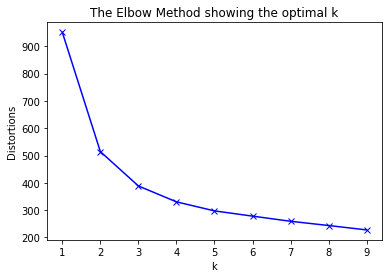

In [31]:
# Create list of distortions for each K value
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(x_train)
    kmeanModel.fit(x_train)
    distortions.append(sum(np.min(cdist(x_train, kmeanModel.cluster_centers_, 'euclidean'), axis=1))/ X.shape[0])

# plot the Elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortions')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [32]:
X = np.array(x_train)
Y = np.array(y_train)

In [16]:
y_pred = KMeans(n_clusters=2, random_state=42).fit_predict(X)

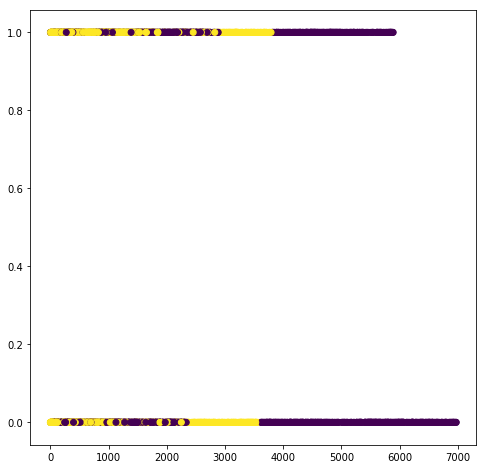

In [17]:
plt.figure(figsize=(8,8))
plt.scatter(X[:,0], X[:,1], c=y_pred)

In [18]:
# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_pred, Y))

Comparing k-means clusters against the data:
col_0    0     1
row_0           
0      113  1501
1      118  1466


In [ ]:
prediction = KMeans(n_clusters=2).fit_predict(X)

plt.figure(figsize=(8,8))
plt.scatter(X[:,0], X[:,1], c=prediction)
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=2).fit(X, Y)
y_pred = kmeans.predict(X)

print(pd.crosstab(y_pred, Y))

In [ ]:
correct = 0
for i in range(len(X)):
    predict_me = np.array(X[i].astype(float))
    predict_me = predict_me.reshape(-1, len(predict_me))
    prediction = kmeans.predict(predict_me)
    if prediction[0] == Y[i]:
        correct += 1

print(correct/len(X))

In [ ]:
kmeans = KMeans(n_clusters=2, max_iter=600, algorithm='auto').fit(X)

In [ ]:
correct = 0
for i in range(len(X)):
    predict_me = np.array(X[i].astype(float))
    predict_me = predict_me.reshape(-1, len(predict_me))
    prediction = kmeans.predict(predict_me)
    if prediction[0] == Y[i]:
        correct += 1

print(correct/len(X))

In [ ]:
# Break into a set of features
x_train = x_train.iloc[:, :12]
# Create n-dimensional array of training data X
x_train = x_train.values
print(x_train)

In [ ]:
# Visualize clusters from PCAs
plt.figure(figsize=(8,8))
plt.scatter(x_train[:,0], x_train[:,1], c = y_pred)
plt.show()

- Predict Runner Type category
- Evaluate accuracy of model
- Create visualizations clusters and relationships that correspond with your prediction to tell a data story
- Write a Data Story